<a href="https://colab.research.google.com/github/rjsdn2308/machine-learning-practice/blob/main/250604_random_image_segrmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras import backend as K

# 랜덤 이미지 생성 및 확인

In [ ]:
def generate_p_data(num_samples=100, img_size=128):

    X = np.random.choice(
        [0.8, 0.4, 0.1],  # 이미지 픽셀 타입
        size=(num_samples, img_size, img_size, 1),
        p=[0.05, 0.25, 0.7]  # 픽셀 비율 설정
    )
    Y = (X > 0.5).astype(np.float32)  # Threshold를 기준으로 마스크 생성
    return X, Y

In [ ]:
sample = generate_p_data(num_samples=100, img_size=128)
sample[0].shape

(100, 128, 128, 1)

In [ ]:
sample[1].shape

(100, 128, 128, 1)

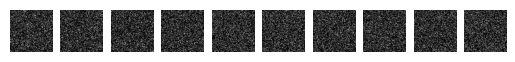

In [ ]:
#sample 출력
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(sample[0][i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
X, Y = generate_p_data(num_samples=200, img_size=128)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 세그멘테이션 성능 평가 지표

In [ ]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

# 모델 정의

In [ ]:
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # 다운샘플링
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # 업샘플링
    u1 = UpSampling2D((2, 2))(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

In [ ]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',iou_coef,dice_coef])

# 모델 학습 및 성능 평가

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=16)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 371ms/step - accuracy: 0.9278 - dice_coef: 0.0780 - iou_coef: 0.0417 - loss: 0.7552 - val_accuracy: 0.9499 - val_dice_coef: 0.0813 - val_iou_coef: 0.0432 - val_loss: 0.3544
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.9498 - dice_coef: 0.0552 - iou_coef: 0.0302 - loss: 0.2791 - val_accuracy: 0.9499 - val_dice_coef: 0.0519 - val_iou_coef: 0.0288 - val_loss: 0.2158
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.9496 - dice_coef: 0.0456 - iou_coef: 0.0252 - loss: 0.2173 - val_accuracy: 0.9499 - val_dice_coef: 0.0536 - val_iou_coef: 0.0297 - val_loss: 0.2142
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.9498 - dice_coef: 0.0503 - iou_coef: 0.0275 - loss: 0.2126 - val_accuracy: 0.9499 - val_dice_coef: 0.0529 - val_iou_coef: 0.0296 - val_loss: 0.2074
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.9498 - dice_coef: 0.0536 - iou_coef: 0.0293 - loss: 0.2053 - val_accuracy: 0.

In [ ]:
loss, accuracy, iou, dc = model.evaluate(X_test, Y_test)
print(f"test loss: {loss:.4f}, test accuracy: {accuracy:.4f}, dice coef: {dc}, iou coef: {iou}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9983 - dice_coef: 0.7458 - iou_coef: 0.5959 - loss: 0.0275 
test loss: 0.0275, test accuracy: 0.9983, dice coef: 0.7458467483520508, iou coef: 0.596337616443634


In [ ]:
preds = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 


In [ ]:
def plot_results(X, Y_true, Y_pred, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y_true[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(Y_pred[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

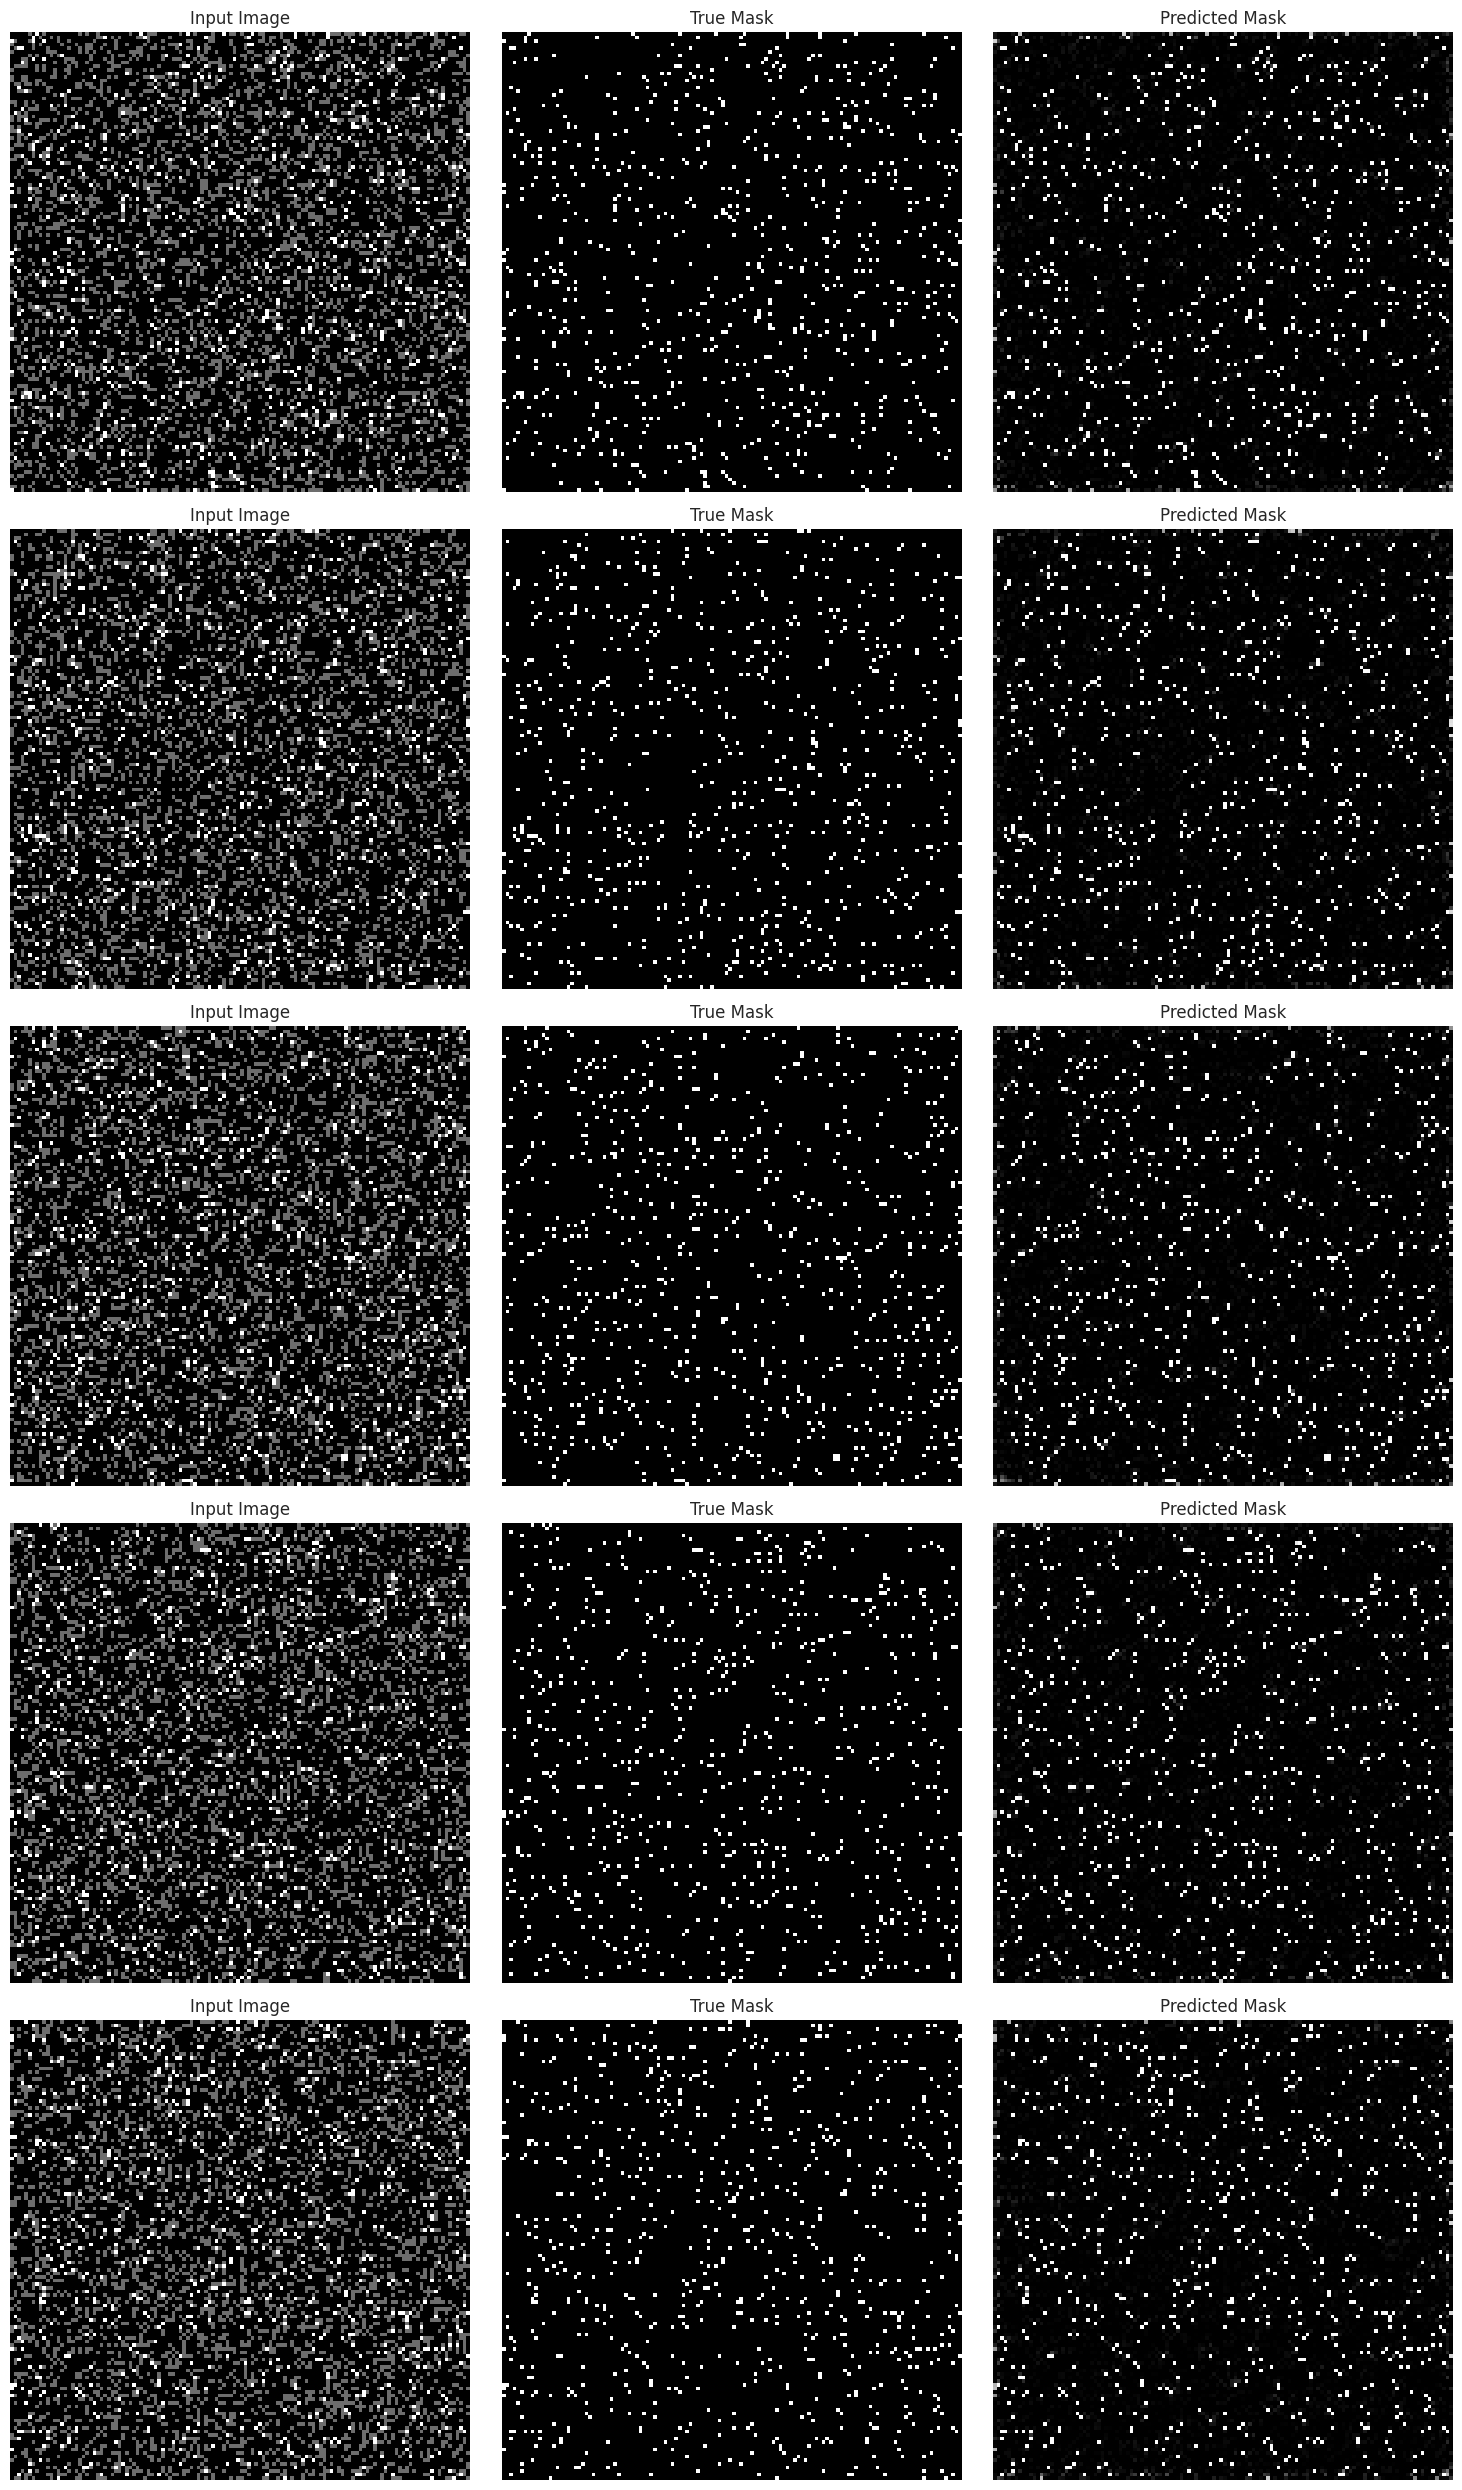

In [ ]:
plot_results(X_test, Y_test, preds)